# Data cleaning, so we can build a classifiier

### **Note:** Remember to check which environment this notebook is using!

## Steps in this notebook
1. Get the packages we need (install -> import)
2. `emnist` pulls a clean dataset of handwritten characters
    1. Clean dataframes are `raw_train` and `raw_test`
    2. Each has only two columns
        1. 'image' - 28x28 pixel array images of handwritten characters
        2. 'label' - different number for class of digit: 0 -> 0, 10 -> A, 61 -> z
3. Demonstrate basic plotting of the images
4. Intentionally dirty this clean dataset
    1. Dirty dataframes are `dirty_train` and `dirty_test`
    2. Look through how the dirtying process works for ideas on how to clean up
5. Space for whatever you're going to do next
    1. Get cleaning with pandas
    2. Build classifiers with the data you've cleaned
    3. Skip data cleaning and build classifier with the raw data

# Install packages

Uncomment the followinig lines the first time running this notebook in this environment
`%conda install pandas numpy emnist matplotlib`
`%pip install emnist`

In [63]:
# Import packages
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emnist
from hashlib import sha1
%conda install pandas numpy emnist matplotlib 
%pip install emnist

Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - emnist

Current channels:

  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [64]:
# Load the data, and reshape it into a 28x28 array

# The size of each image is 28x28 pixels
size = 28 

# Extract the training split as images and labels
image, label = emnist.extract_training_samples('byclass')

# Add columns for each pixel value (28x28 = 784 columns)
raw_train = pd.DataFrame()

# Add a column showing the label
raw_train['label'] = label

# Add a column with the image data as a 28x28 array
raw_train['image'] = list(image)


# Repeat for the test split
image, label = emnist.extract_test_samples('byclass')
raw_test = pd.DataFrame()
raw_test['label'] = label
raw_test['image'] = list(image)


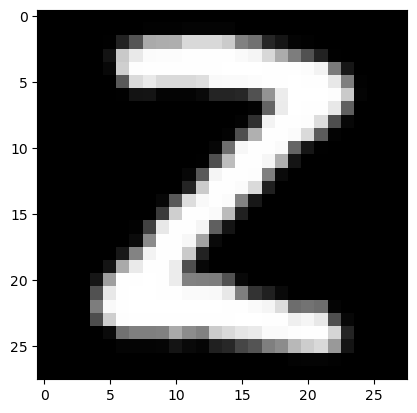

In [65]:
# We can plot individual images using matplotlib
plt.imshow(raw_train['image'][0], cmap='gray')
plt.show() # Show the plot (optional with a single image)

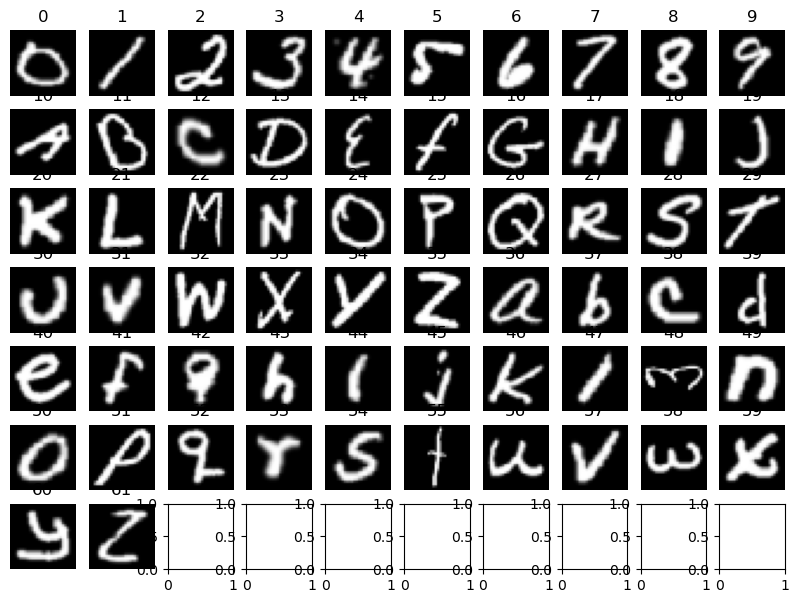

In [66]:
# Get the first row for each label
firsts = raw_train.groupby('label').first().reset_index()

# Build a plot with the first image for each label
fig, ax = plt.subplots(7, 10, figsize=(10, 7))
for i in range(62):
    ax[i//10, i%10].imshow(firsts['image'][i], cmap='gray')
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].set_title(firsts['label'][i])

# Getting dirty

Now that we've got the data in good shape, let's rough it up a little.

- [x] Add `predicit` col with confidence probabilities from a previous model
- [x] Numerical:
    - [x] outlier
    - [x] out-of-bounds
- [x] Labels: missing(Null, None, "", " "), name that number, double-struck
- [x] Image: zeroed, null? dimensions?
- [x] Image: add noise
- [x] Image: flip horizonally
- [x] Duplicated rows

In [67]:
# Now let's mess up the data a bit

# Percent of the time something dirty happens (0.1%) for each method
pct = 0.001 

# Copy the splits into new dataframes to mess up
dirty_train = raw_train.copy()
dirty_test  = raw_test.copy()

# Add a column for a hash of the images (should make it easier to compare them)
dirty_train['image_hash'] = dirty_train['image'].apply(lambda x: sha1(x.tobytes()).hexdigest())
dirty_test['image_hash']  =  dirty_test['image'].apply(lambda x: sha1(x.tobytes()).hexdigest())

# For each row, 0.1% of the time, duplicate the row
dirty_train = pd.concat([dirty_train, dirty_train.sample(frac=pct)])
dirty_test  = pd.concat([dirty_test,   dirty_test.sample(frac=pct)])

# For each row, 0.1% of the time, zero out the image array
dirty_train['image'] = dirty_train['image'].apply(lambda x: np.zeros((size, size)) if np.random.rand() < pct else x)
dirty_test['image']  =  dirty_test['image'].apply(lambda x: np.zeros((size, size)) if np.random.rand() < pct else x)

# Add a column for classification scores from a previous model
dirty_train['predict'] = np.random.normal(0.75, 0.1, dirty_train.shape[0])
dirty_test['predict']  = np.random.normal(0.75, 0.1, dirty_test.shape[0])

# For each row, 0.1% of the time, replace the predict column with a normal distribution centered on 0.25
dirty_train['predict'] = dirty_train['predict'].apply(lambda x: np.random.normal(0.25, 0.1) if np.random.rand() < pct else x)
dirty_test['predict']  =  dirty_test['predict'].apply(lambda x: np.random.normal(0.25, 0.1) if np.random.rand() < pct else x)

# For each row, 0.1% of the time, add/subtract 1 to the predict column
dirty_train['predict'] = dirty_train['predict'].apply(lambda x: x + 1 if np.random.rand() < pct/2 else x)
dirty_test['predict']  =  dirty_test['predict'].apply(lambda x: x + 1 if np.random.rand() < pct/2 else x)
dirty_train['predict'] = dirty_train['predict'].apply(lambda x: x - 1 if np.random.rand() < pct/2 else x)
dirty_test['predict']  =  dirty_test['predict'].apply(lambda x: x - 1 if np.random.rand() < pct/2 else x)

# For each row, 0.1% of the time, choose a column at random and set it to NaN
dirty_train = dirty_train.apply(lambda row: row if np.random.rand() > pct else row.apply(lambda x: np.nan if np.random.rand() > 0.5 else x), axis=1)
dirty_test  =  dirty_test.apply(lambda row: row if np.random.rand() > pct else row.apply(lambda x: np.nan if np.random.rand() > 0.5 else x), axis=1)

# Mislabel 0.1% of the data with strings that look like labels or missing values (e.g., names like "one", numbers greater than 62, " ")
# Create a list of bad labels
bad_labels = ['number', 'letter', 'maybe three?', 'think this is a seven', ' ', '', 'NaaN', 'Null'] + list(range(63, 100))
# For 0.1% of the rows, randomly choose a bad label
dirty_train['label'] = dirty_train['label'].apply(lambda x: np.random.choice(bad_labels) if np.random.rand() < pct else x)
dirty_test['label']  =  dirty_test['label'].apply(lambda x: np.random.choice(bad_labels) if np.random.rand() < pct else x)




# TEMPLATE: For each row, PCT% of the time, randomly apply METHOD() to the COLUMN
# df['COLUMN'] = dirty_train['column'].apply(lambda x: METHOD(x) if np.random.rand() < PCT else x)

# Not applying these for now, but they're here if you want to try them

# For each row, randomly decide whether to apply a random noise
# dirty_train['image'] = dirty_train['image'].apply(lambda x: x + np.random.rand(size, size) if np.random.rand() < 0.1 else x)

# For each row, randomly decide whether to flip the image horizontally
#dirty_train['image'] = dirty_train['image'].apply(lambda x: np.flip(x, axis=1) if np.random.rand() < 0.1 else x)


# Exercise

The changes above were applied randomly, so we'll need to find them and make a plan to fix them.

- [ ] Create a column to identify whether each row came from *train* or *test*
- [ ] (optional) Merge the data into a single
- [ ] Explore the data to understand what's in it
- [ ] List potential data issues to fix
    - Duplicate rows
    - Missing values
    - Outliers and out-of-bounds issues
    - Label issues
    - Image issues
    - Zeroed values
- [ ] Create a friendlier column for image labels
- [ ] Recategorizing the labels into 'numbers' and 'letters'
- [ ] Bin the prediction scores of the previous model

In [68]:
# Let's start cleaning!

# Labels! They're hard to understand as numbers, so let's map them to characters
# We can do this by manually creating a dictionary:
LABELS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
          'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# Or generate the list of labels using the following code:
# create the characters list, which is the digits, then uppercase, then lowercase
chars = string.digits + string.ascii_uppercase + string.ascii_lowercase
# create the dictionary mapping the numbers to the characters
num_to_char = {i: chars[i] for i in range(len(chars))}

# Add a column showing which split (train vs test) each row came from
raw_train['split'] = 'train'
raw_test['split']  = 'test'
dirty_train['split'] = 'train'
dirty_test['split'] = 'test'

# Add a column for a hash of the images (might make it easier to compare them)
dirty_train['image_hash'] = dirty_train['image'].apply(lambda x: sha1(np.ascontiguousarray(x)).hexdigest())
dirty_test['image_hash']  =  dirty_test['image'].apply(lambda x: sha1(np.ascontiguousarray(x)).hexdigest())

In [69]:
merged = pd.concat([dirty_test, dirty_train], axis=0)

In [71]:
# Get basic information about the DataFrame
print(merged.info())

print(merged.describe())

print(merged.head())


<class 'pandas.core.frame.DataFrame'>
Index: 815069 entries, 0 to 88067
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   label       814633 non-null  object 
 1   image       814656 non-null  object 
 2   image_hash  815069 non-null  object 
 3   predict     814641 non-null  float64
 4   split       815069 non-null  object 
dtypes: float64(1), object(4)
memory usage: 37.3+ MB
None
             predict
count  814641.000000
mean        0.749486
std         0.105899
min        -0.534846
25%         0.682199
50%         0.749810
75%         0.817528
max         2.125211
  label                                              image  \
0  18.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1  36.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2   0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3   3.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4  33.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [72]:
# Check for duplicate rows based on the subset of columns
merged['is_duplicate'] = merged.duplicated(subset=['image_hash', 'label'])

# Count the number of duplicate rows
num_duplicates = merged['is_duplicate'].sum()

# Display or print the duplicate rows
duplicate_rows = merged[merged['is_duplicate']]
print("The total number of duplicates (rows):", num_duplicates)
print("The actual duplicate rows:", duplicate_rows)


The total number of duplicates (rows): 1924
The actual duplicate rows:        label                                              image  \
4610     NaN                                                NaN   
5482     NaN                                                NaN   
9953     NaN                                                NaN   
12650   11.0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
12856    6.0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...      ...                                                ...   
406959   3.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
414824  47.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
545321  56.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
37615    6.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
88067   18.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                      image_hash   predict  split  \
4610    c1cee032e48ec3238bd16efe4a9e72da72e35e08  0.608

In [73]:
merged[['is_duplicate']]

,is_duplicate
0,False
1,False
2,False
3,False
4,False
...,...
406959,True
414824,True
545321,True
37615,True


In [74]:
# Dropping duplicates
#merged.drop_duplicates(subset=['image_hash', 'label', 'predict'], inplace=True)

# Check rows after dropping duplicate rows
#print("Number of Rows after dropping duplicates:", len(merged))

# Check for duplicate rows based on the subset of columns
#merged['is_duplicate'] = merged.duplicated(subset=['image_hash', 'label', 'predict'])

# Count the number of duplicate rows
#num_duplicates = merged['is_duplicate'].sum()

# Display or print the duplicate rows
#duplicate_rows = merged[merged['is_duplicate']]
#print("The total number of duplicates (rows):", num_duplicates)
#print("The actual duplicate rows:", duplicate_rows)



In [75]:
# Check for missing values
missing_values = merged.isnull().sum()


# Display the count of missing values for each column
print("Missing Values:", missing_values)


Missing Values: label           436
image           413
image_hash        0
predict         428
split             0
is_duplicate      0
dtype: int64


In [76]:
# Drop missing values in merged. Drop rows with missing values in any column.
#merged = merged.dropna()


In [77]:
# Check for missing values
#missing_values = merged.isnull().sum()

# Display the count of missing values for each column
#print("Number of missing values after drop:", missing_values)


In [78]:
# Checking for outliers and out of boundaries
predict_description = merged['predict'].describe()
print(predict_description)

merged['is_outbound'] = (merged['predict'] < 0) | (merged['predict'] > 1)

filtered_merged = merged[merged['is_outbound'] == "false"]

Q1 = filtered_merged['predict'].quantile(0.25)
Q3 = filtered_merged['predict'].quantile(0.75)
IQR = Q3 - Q1
mean_predict = merged['predict'].mean()
merged['is_outlier'] = merged.apply(lambda row: (not row['is_outbound']) and 
                                    (row['predict'] < (mean_predict - 1.5 * IQR) or 
                                     row['predict'] > (mean_predict + 1.5 * IQR)), axis=1)

count    814641.000000
mean          0.749486
std           0.105899
min          -0.534846
25%           0.682199
50%           0.749810
75%           0.817528
max           2.125211
Name: predict, dtype: float64


In [79]:
# Creating a friendlier column for image labels
merged['mapped_label'] = merged['label'].map(num_to_char)
print(merged[['mapped_label']])


       mapped_label
0                 I
1                 a
2                 0
3                 3
4                 X
...             ...
406959            3
414824            l
545321            u
37615             6
88067             I

[815069 rows x 1 columns]


In [80]:
# Addressing label issues
merged['bad_label'] = merged['label'].apply(lambda x: pd.isnull(pd.to_numeric(x, errors='coerce')))

In [81]:
# Addressing image issues
merged['image_zeroed'] = merged['image'].apply(lambda img: np.all(img == 0))

In [90]:
# Checking for zeroed values in the 'image' column
zeroed_val = merged['image'].apply(lambda x: np.any(x == 0) if isinstance(x, np.ndarray) else False)
print("Are there any zeroed Values in 'image' column?")
print(zeroed_val.any())



Are there any zeroed Values in 'image' column?
True


In [91]:
import pandas as pd

def label_category(value):
    if pd.isnull(value):
        return pd.NA  # Use pd.NA for missing values
    # Try to convert to numeric, and check if the result is not NaN
    elif not pd.isnull(pd.to_numeric(value, errors='coerce')):
        return 'number'
    elif isinstance(value, str) and value.isalpha():
        return 'letter'
    else:
        return pd.NA  # Use pd.NA for any other case that is considered missing

In [92]:
# Identifying whether it is a number or letter
merged['label_cat'] = merged['mapped_label'].apply(label_category)

In [93]:
# Bin the prediction scores of the previous model
merged['predict_quantile'] = pd.qcut(merged['predict'], 4)
print(merged['predict_quantile'])

0         (-0.536, 0.682]
1         (-0.536, 0.682]
2           (0.682, 0.75]
3          (0.818, 2.125]
4           (0.75, 0.818]
               ...       
406959    (-0.536, 0.682]
414824      (0.682, 0.75]
545321      (0.682, 0.75]
37615       (0.75, 0.818]
88067     (-0.536, 0.682]
Name: predict_quantile, Length: 815069, dtype: category
Categories (4, interval[float64, right]): [(-0.536, 0.682] < (0.682, 0.75] < (0.75, 0.818] < (0.818, 2.125]]
